In [1]:
import pickle
import pandas as pd
import numpy as np

In [2]:
df = pd.read_pickle('turbine1_df_final.pkl')



In [3]:
df['# Date and time'] = pd.to_datetime(df['# Date and time'])
# Perform cyclic encoding for month and hour
df['month_sin'] = np.sin(2 * np.pi * df['# Date and time'].dt.month / 12)
df['month_cos'] = np.cos(2 * np.pi * df['# Date and time'].dt.month / 12)

df['hour_sin'] = np.sin(2 * np.pi * df['# Date and time'].dt.hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['# Date and time'].dt.hour / 24)

# Drop the original 'Date and time' column
df.drop('# Date and time', axis=1, inplace=True)

In [4]:
from sklearn.model_selection import train_test_split

# Split the dataset into training, validation, and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=False)
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42, shuffle=False)

# Print the shape of each split
print('Training set shape:', train_df.shape)
print('Validation set shape:', val_df.shape)
print('Testing set shape:', test_df.shape)
test_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

Training set shape: (78436, 66)
Validation set shape: (26146, 66)
Testing set shape: (26146, 66)


In [5]:
from pytorch_tabnet.tab_model import TabNetRegressor

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import pandas as pd
import numpy as np
np.random.seed(0)


import os


In [6]:
train_indices = train_df.index
valid_indices = val_df.index
test_indices = test_df.index
print(valid_indices)

RangeIndex(start=0, stop=26146, step=1)


In [7]:
target = 'Power (kW)'
features = [ col for col in train_df.columns if col not in target] 

X_train = train_df[features].values[train_indices]
y_train = train_df[target].values[train_indices].reshape(-1, 1)

X_valid = val_df[features].values[valid_indices]
y_valid = val_df[target].values[valid_indices].reshape(-1, 1)

X_test = test_df[features].values[test_indices]
y_test = test_df[target].values[test_indices].reshape(-1, 1)


In [8]:
max_epochs = 78 if not os.getenv("CI", False) else 2

In [9]:
from pytorch_tabnet.augmentations import RegressionSMOTE
aug = RegressionSMOTE(p=0.2)


In [10]:

clf = TabNetRegressor(n_d=8, n_a=8, n_steps=8 ,gamma=1.95)


/home/krishna/miniconda3/envs/dl/lib/python3.11/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [11]:
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['rmsle', 'mae', 'rmse', 'mse'],
    max_epochs=max_epochs,
    patience=50,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    augmentations=aug, #aug
) 

epoch 0  | loss: 1.06245 | train_rmsle: 0.04198 | train_mae: 0.24727 | train_rmse: 0.27729 | train_mse: 0.07689 | valid_rmsle: 0.03929 | valid_mae: 0.23331 | valid_rmse: 0.2616  | valid_mse: 0.06844 |  0:00:08s
epoch 1  | loss: 0.06158 | train_rmsle: 0.0131  | train_mae: 0.12153 | train_rmse: 0.18244 | train_mse: 0.03328 | valid_rmsle: 0.01083 | valid_mae: 0.11154 | valid_rmse: 0.16019 | valid_mse: 0.02566 |  0:00:16s
epoch 2  | loss: 0.01144 | train_rmsle: 0.01181 | train_mae: 0.12113 | train_rmse: 0.17232 | train_mse: 0.02969 | valid_rmsle: 0.00982 | valid_mae: 0.10763 | valid_rmse: 0.15358 | valid_mse: 0.02359 |  0:00:23s
epoch 3  | loss: 0.00774 | train_rmsle: 0.00835 | train_mae: 0.09962 | train_rmse: 0.14865 | train_mse: 0.0221  | valid_rmsle: 0.00638 | valid_mae: 0.08559 | valid_rmse: 0.12564 | valid_mse: 0.01579 |  0:00:31s
epoch 4  | loss: 0.00601 | train_rmsle: 0.00567 | train_mae: 0.07463 | train_rmse: 0.12832 | train_mse: 0.01647 | valid_rmsle: 0.00406 | valid_mae: 0.06226 

/home/krishna/miniconda3/envs/dl/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [12]:
preds = clf.predict(X_test)

y_true = y_test

test_score = mean_squared_error(y_pred=preds, y_true=y_true)


In [13]:
print(test_score)

0.0017761602307688475


In [14]:
clf.feature_importances_

array([4.26892227e-06, 0.00000000e+00, 0.00000000e+00, 3.00723057e-02,
       0.00000000e+00, 1.81987064e-06, 1.37099386e-01, 3.07597264e-01,
       1.17412334e-05, 0.00000000e+00, 0.00000000e+00, 7.68810592e-02,
       6.31930090e-04, 8.53033960e-03, 1.69922775e-02, 8.09343194e-03,
       1.85524606e-08, 0.00000000e+00, 5.99931009e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 7.60999255e-05, 1.14790590e-06,
       1.17366399e-01, 1.14198997e-02, 0.00000000e+00, 3.89959469e-06,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.32325158e-05,
       0.00000000e+00, 6.57038847e-05, 1.35262607e-02, 2.21752146e-05,
       0.00000000e+00, 6.23984265e-02, 8.66896181e-03, 0.00000000e+00,
       2.79329075e-03, 1.93734536e-06, 9.73141818e-04, 0.00000000e+00,
       2.06456979e-06, 5.23236864e-02, 1.94160263e-02, 4.95664089e-03,
       8.15198301e-04, 4.23687933e-02, 4.42582323e-03, 1.96317046e-02,
       0.00000000e+00, 2.24109549e-03, 0.00000000e+00, 3.52501762e-03,
      

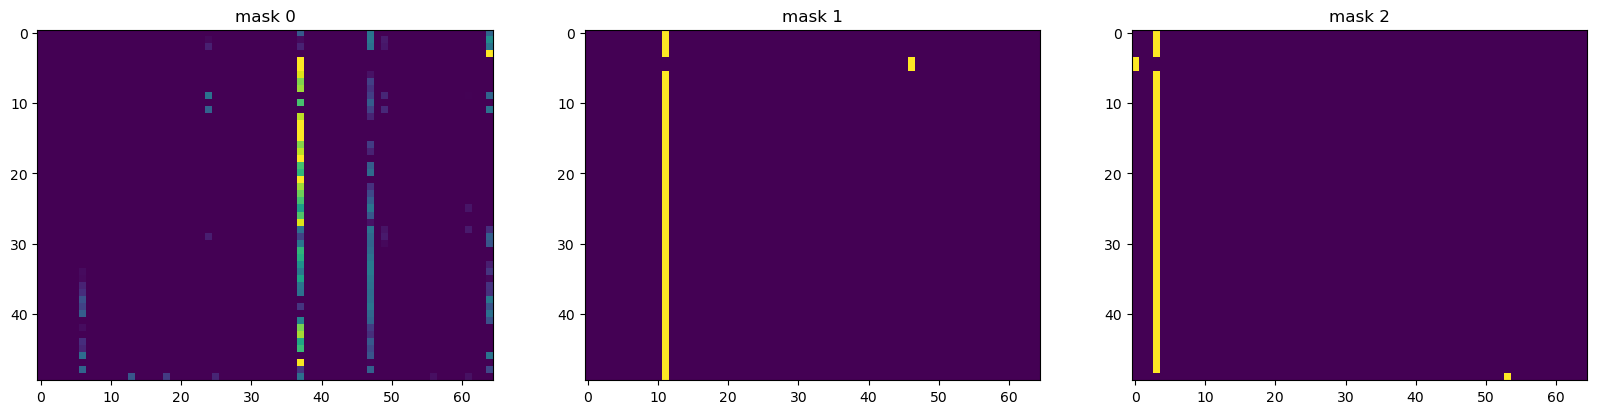

In [15]:
explain_matrix, masks = clf.explain(X_test)
from matplotlib import pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")

In [16]:
from xgboost import XGBRegressor

reg_xgb = XGBRegressor(max_depth=8,
    learning_rate=0.1,
    n_estimators=1000,
    verbosity=0,
    silent=None,
    objective='reg:linear',
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,)

reg_xgb.fit(X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=40,
        verbose=10)

/home/krishna/miniconda3/envs/dl/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.32395
[10]	validation_0-rmse:0.11461
[20]	validation_0-rmse:0.04277
[30]	validation_0-rmse:0.02010
[40]	validation_0-rmse:0.01466
[50]	validation_0-rmse:0.01361
[60]	validation_0-rmse:0.01340
[70]	validation_0-rmse:0.01335
[80]	validation_0-rmse:0.01333
[90]	validation_0-rmse:0.01331
[100]	validation_0-rmse:0.01329
[110]	validation_0-rmse:0.01329
[120]	validation_0-rmse:0.01329
[130]	validation_0-rmse:0.01331
[138]	validation_0-rmse:0.01330


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=0,
             max_depth=8, max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, n_estimators=1000, n_jobs=-1,
             nthread=None, num_parallel_tree=None, objective='reg:linear', ...)

In [17]:
print(reg_xgb.feature_importances_)


[3.78227234e-02 5.35090003e-05 1.02894781e-04 1.49786865e-04
 1.04764847e-04 1.63700344e-04 7.86159754e-01 1.66692644e-01
 1.62399039e-04 1.36344403e-04 1.23864607e-04 3.25831398e-03
 1.11413574e-04 1.12267953e-04 1.12513058e-04 1.15435665e-04
 9.74491413e-05 7.48724633e-05 7.42438278e-05 8.17979526e-05
 9.10188464e-05 8.10626516e-05 1.62408571e-04 9.22517429e-05
 6.92411995e-05 6.06398789e-05 6.15876997e-05 2.05707460e-04
 9.76096126e-05 9.17855941e-05 7.44235294e-05 8.87563365e-05
 7.44791614e-05 6.22049338e-05 6.85490304e-05 6.57211494e-05
 6.70680165e-05 1.42811637e-04 9.89059918e-05 9.52478367e-05
 1.08733664e-04 8.95528574e-05 1.07477274e-04 1.15086681e-04
 8.60139335e-05 7.83390569e-05 6.42610321e-05 1.03312457e-04
 9.24527631e-05 8.45081231e-05 7.72333588e-05 8.96328202e-05
 2.81332632e-05 2.14036554e-04 3.18860257e-05 3.27980561e-05
 5.04529162e-05 2.01942370e-04 7.67721576e-05 5.93836303e-05
 6.03012268e-05 2.65900104e-04 1.67839185e-04 8.06350436e-05
 7.12153196e-05]


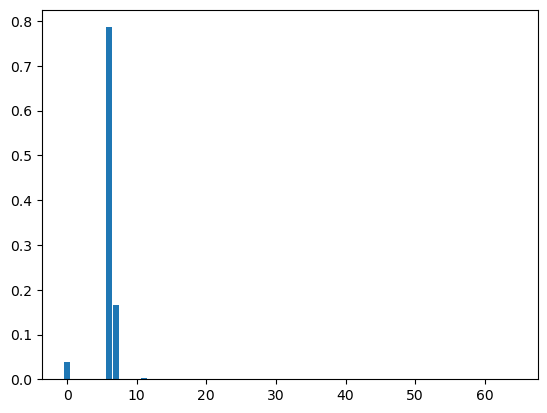

In [28]:
import matplotlib
from matplotlib import pyplot as plt

xgb_feature_importance_ = reg_xgb.feature_importances_
# plotclf_xgb.feature_importances_
plt.bar(range(len(xgb_feature_importance_)),xgb_feature_importance_)
plt.show()

In [38]:
print(reg_xgb.feature_importances_)

[3.78227234e-02 5.35090003e-05 1.02894781e-04 1.49786865e-04
 1.04764847e-04 1.63700344e-04 7.86159754e-01 1.66692644e-01
 1.62399039e-04 1.36344403e-04 1.23864607e-04 3.25831398e-03
 1.11413574e-04 1.12267953e-04 1.12513058e-04 1.15435665e-04
 9.74491413e-05 7.48724633e-05 7.42438278e-05 8.17979526e-05
 9.10188464e-05 8.10626516e-05 1.62408571e-04 9.22517429e-05
 6.92411995e-05 6.06398789e-05 6.15876997e-05 2.05707460e-04
 9.76096126e-05 9.17855941e-05 7.44235294e-05 8.87563365e-05
 7.44791614e-05 6.22049338e-05 6.85490304e-05 6.57211494e-05
 6.70680165e-05 1.42811637e-04 9.89059918e-05 9.52478367e-05
 1.08733664e-04 8.95528574e-05 1.07477274e-04 1.15086681e-04
 8.60139335e-05 7.83390569e-05 6.42610321e-05 1.03312457e-04
 9.24527631e-05 8.45081231e-05 7.72333588e-05 8.96328202e-05
 2.81332632e-05 2.14036554e-04 3.18860257e-05 3.27980561e-05
 5.04529162e-05 2.01942370e-04 7.67721576e-05 5.93836303e-05
 6.03012268e-05 2.65900104e-04 1.67839185e-04 8.06350436e-05
 7.12153196e-05]


In [18]:
preds = np.array(reg_xgb.predict(X_valid))
valid_auc = mean_squared_error(y_pred=preds, y_true=y_valid)
print(valid_auc)

preds = np.array(reg_xgb.predict(X_test))
test_auc = mean_squared_error(y_pred=preds, y_true=y_test)
print(test_auc)


0.00017644276280005152
0.00014436806643773912


In [19]:
# save tabnet model
saving_path_name = "./tabnet_model_test_1"
saved_filepath = clf.save_model(saving_path_name)

Successfully saved model at ./tabnet_model_test_1.zip


In [20]:
# define new model with basic parameters and load state dict weights
loaded_clf = TabNetRegressor()
loaded_clf.load_model(saved_filepath)

/home/krishna/miniconda3/envs/dl/lib/python3.11/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [21]:
loaded_preds = loaded_clf.predict(X_test)
loaded_test_mse = mean_squared_error(loaded_preds, y_test)

print(f"FINAL TEST SCORE FOR dataset : {loaded_test_mse}")


FINAL TEST SCORE FOR dataset : 0.0017761602307688475


In [22]:
assert(test_score == loaded_test_mse)


In [ ]:
import pickle
train_df.to_pickle('train.pkl')
val_df.to_pickle('val.pkl')
test_df.to_pickle('test.pkl')